In [1]:
# Import necessary libraries
import spacy
import nltk
from nltk.util import ngrams
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import unicodedata
from datasets import load_dataset
import jsonlines
from huggingface_hub import hf_hub_download

import preprocessor as p
from nltk.tokenize import TweetTokenizer
from nltk.corpus import words

nltk.download("punkt")
nltk.download("punkt_tab")

tokenizer = TweetTokenizer(
    preserve_case=False,
    strip_handles=True,
    reduce_len=True
)

[nltk_data] Downloading package punkt to /home/moi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/moi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Datasets for training n-grams:  
- "aisyahhrazak/crawl-fiksyenshasha" :   
    - https://huggingface.co/datasets/aisyahhrazak/crawl-fiksyenshasha  
    - Data scraped from https://fiksyenshasha.com/  
    - A website for submitting (mostly horror, personal or fiction) stories.  
    - text columns: headline, content, comment  

- "aisyahhrazak/ms-melakahariini"
    - https://huggingface.co/datasets/aisyahhrazak/ms-melakahariini
    - Data scraped from https://www.melakahariini.my/
    - News articles
    - text columns: headline, content

- "malaysia-ai/fb-malaysian-pages" :  
    - https://huggingface.co/datasets/malaysia-ai/fb-malaysian-pages  
    - Data from Malaysian Facebook pages
    - text columns: text




In [2]:
# Load "aisyahhrazak/crawl-fiksyenshasha" dataset

dataset = load_dataset(
    "aisyahhrazak/crawl-fiksyenshasha",
    split="train"
)

# create a list to collect text
all_texts_c = []

for row in dataset:
    # headline (string)
    if row["headline"]:
        all_texts_c.append(row["headline"])

    # content (list of strings)
    if row["content"]:
        all_texts_c.extend(row["content"])

    # comment (list of strings)
    if row["comment"]:
        all_texts_c.extend(row["comment"])




In [3]:
print("Collected:", len(all_texts_c))
print("First 3 elements:", all_texts_c[:3])


Collected: 353160
First 3 elements: ['KISAH SERAM JALAN SANDAKAN-KOTA KINABALU', 'Kisah ini bermula ketika saya berumur 23 tahun. Dalam umur yang masih muda saya sudah bekerja d sebuah agensi pekerjaan di sandakan. Jiwa remaja sememangnya banyak perkara yang ingin dilakukan. Saya, nana dan wan merancang untuk ke kota kinabalu awal bulan april. Seperti yang sudah di rancang. Tepat jm6 petang kami bertolak dari sandakan. Disebabkan saya masih kerja pada hari itu, kami terpaksa bertolak sebelah petang. Perjalanan dari sandakan ke kota kinabalu memakan masa 7-8jam terpulang dari kelajuan masing2. Okey pada jam7 malam kami singgah mengisi minyak di check point dan membeli makanan ringan utk mengisi perut dalam perjalanan.', 'Semasa kami melalui jalan telupid ranau hati saya merasa tidak sedap. Tapi sebagai pemandu saya kuatkan radio sekali sekala ikut menyanyi. Dalam hati syukur ada bas di belakang. Semasa melalui jlan yang agak gelap (jalan telupid ranau ni memang hutan tiada lampu jalan) 

In [4]:
# Load aisyahhrazak/ms-melakahariini dataset

dataset = load_dataset(
    "aisyahhrazak/ms-melakahariini",
    split="train"
)

# create a list to collect text
all_texts_m = []

for row in dataset:
    # headline (string)
    if row["headline"]:
        all_texts_m.append(row["headline"])

    # content (list of strings)
    if row["content"]:
        all_texts_m.extend(row["content"])



In [5]:
print("Collected:", len(all_texts_m))
print("First 3 elements:", all_texts_m[:3])

Collected: 111155
First 3 elements: ['\nToh Puan Asmah hadir tonton Teater Pukol Anak Sinday Menantu\n', 'AYER KEROH 30 Oktober – Isteri Yang di-Pertua Negeri, Toh Puan Asmah Abd Rahman menghadiri Pementasan Teater Muzikal Peranakan bertajuk Pukol Anak Sinday Menantu di Kompleks Jabatan Kebudayaan dan Kesenian Negara (JKKN) Melaka, di sini malam tadi.', 'Teater perdana itu sebagai penutup tirai bagi sambutan Festival Kemegahan Budaya Baba Nyonya yang berlangsung selama tiga hari bermula 28\xa0 hingga 30 Oktober 2022 bertemakan “Warisan Seni Budaya Baba Nyonya Melaka”.']


In [6]:
# Load "malaysia-ai/fb-malaysian-pages" dataset
# Dataset formatting issue, need to manually read JSONL (inconsistent data types, JSON objects or strings)

file_path = hf_hub_download(
    repo_id="malaysia-ai/fb-malaysian-pages",
    filename="dedup.jsonl",
    repo_type="dataset"
)

all_texts_f = []

with jsonlines.open(file_path) as reader:
    for obj in reader:
        # normal JSON object
        if isinstance(obj, dict):
            text = obj.get("text")

        # string
        elif isinstance(obj, str):
            text = obj

        else:
            continue

        if isinstance(text, str) and text.strip():
            all_texts_f.append(text)



In [7]:
print("Collected:", len(all_texts_f))
print("First 3 elements:", all_texts_f[:3])


Collected: 193363
First 3 elements: ['Adeyyy pooodahhh puiii', 'Bosan la ceramah dia.. dulu sonok gak', 'Memalukan betul.. PM malaysia.\nDunia sedang memerhatikan Malaysia dipimpin oleh orang yang tercemar dgn kes2 mahkamah... \n\nMalaysia PM Picks Graft-Tainted Leader as One of His Deputies https://\nwww.bloomberg.co\nm/news/\narticles/\n2022-12-02/\nmalaysia-pm-pick\ns-graft-tainted\n-leader-as-one-\nof-his-deputies']


In [8]:

# Process datasets
def clean_text(text):
    """
    Cleans and tokenizes text.

    Returns:
        tokenized: list of tokenized sentences (list of lists of words)
    """
    # get rid of URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # split into a list of sentences
    sentences = nltk.sent_tokenize(text)

    tokenized = []

    # split each sentence into a list of words
    for s in sentences:

        # clean: to lowercase, only 
        s = s.lower()
        s = re.sub(r"[^a-zàâéèêëîïôûùüçñ\s]", " ", s)
        s = re.sub(r"\s+", " ", s).strip()

        tokens = nltk.word_tokenize(s)
        tokenized.append(tokens)

    return tokenized



In [9]:
def process(texts):
    """
    Cleans and tokenizes a list of texts.
    """
    all_tokenized = []

    for text in texts:
        tokenized = clean_text(text)
        all_tokenized.extend(tokenized)

    return all_tokenized

In [11]:
all_tokenized_c = process(all_texts_c[:300000])
all_tokenized_f = process(all_texts_f[:300000])
all_tokenized_m = process(all_texts_m[:300000])

In [12]:
all_tokenized = all_tokenized_c[:300000] + all_tokenized_f[:300000] + all_tokenized_m[:300000]

print("Tokenized stories:", all_tokenized_c[:3])
print("Number of sentences:", len(all_tokenized_c))

print("Tokenized Facebook posts:", all_tokenized_f[:3])
print("Number of sentences:", len(all_tokenized_f))

print("Tokenized articles:", all_tokenized_m[:3])
print("Number of sentences:", len(all_tokenized_m))


print("All:", len(all_tokenized))

Tokenized stories: [['kisah', 'seram', 'jalan', 'sandakan', 'kota', 'kinabalu'], ['kisah', 'ini', 'bermula', 'ketika', 'saya', 'berumur', 'tahun'], ['dalam', 'umur', 'yang', 'masih', 'muda', 'saya', 'sudah', 'bekerja', 'd', 'sebuah', 'agensi', 'pekerjaan', 'di', 'sandakan']]
Number of sentences: 1025546
Tokenized Facebook posts: [['adeyyy', 'pooodahhh', 'puiii'], ['bosan', 'la', 'ceramah', 'dia', 'dulu', 'sonok', 'gak'], ['memalukan', 'betul', 'pm', 'malaysia']]
Number of sentences: 241103
Tokenized articles: [['toh', 'puan', 'asmah', 'hadir', 'tonton', 'teater', 'pukol', 'anak', 'sinday', 'menantu'], ['ayer', 'keroh', 'oktober', 'isteri', 'yang', 'di', 'pertua', 'negeri', 'toh', 'puan', 'asmah', 'abd', 'rahman', 'menghadiri', 'pementasan', 'teater', 'muzikal', 'peranakan', 'bertajuk', 'pukol', 'anak', 'sinday', 'menantu', 'di', 'kompleks', 'jabatan', 'kebudayaan', 'dan', 'kesenian', 'negara', 'jkkn', 'melaka', 'di', 'sini', 'malam', 'tadi'], ['teater', 'perdana', 'itu', 'sebagai', 'pe

In [13]:
def count_tokens(list):
    num_tokens = sum(len(sent) for sent in list)
    print("Total number of tokens:", num_tokens)

count_tokens(all_texts_c)
count_tokens(all_texts_f)
count_tokens(all_texts_m)

Total number of tokens: 76602377
Total number of tokens: 11081869
Total number of tokens: 22787810


In [14]:

# Preprocess tweets
def preprocess_tweets(text):
    if not isinstance(text, str):
            return ""

    # Clean tweet-specific noise
    text = p.clean(text)  # removes URLs, mentions, emojis, RT, etc.

    #use regex to clean links that p.clean might miss
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Tokenize
    tokens = tokenizer.tokenize(text)

    # Keep only alphabetic tokens (supports accented chars)
    tokens = [t for t in tokens if t.isalpha()]

    return " ".join(tokens)

# -------- load ONE file --------
file_path = "tweets/extracted_data0.csv"

df = pd.read_csv(file_path)


# Get rid of duplicates
df = df.drop_duplicates(subset=["tweet_text"])

#Only keep tweets not in English
#df = df[df["tweet_lang"] != "en"]

# -------- clean tweets --------
df["clean_text"] = df["tweet_text"].apply(preprocess_tweets)

# -------- remove short tweets (<4 words) --------
df["word_count"] = df["clean_text"].str.split().str.len()
df_clean = df[df["word_count"] >= 4]

# -------- final list of cleaned tweets --------
cleaned_tweets = df_clean["clean_text"].tolist()

#Make a second list that also has the languages in "tweet_lang" column
cleaned_tweets_with_lang = df_clean[["clean_text", "tweet_lang"]].values.tolist()

/tmp/ipykernel_24832/2859428832.py:23: DtypeWarning: Columns (1,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [15]:
print(cleaned_tweets[:20])  # Print first 5 cleaned tweets for verification
print(len(cleaned_tweets))  # Print first 5 cleaned tweets for verification

['rasanya takde mufti yang ulas so boleh ikut mufti perlis hukumnya unless ada pandangan mufti lain', 'pmr outreach sekitar kawasan taman sri petaling di parlimen p seputeh pada april kawasan yang', 'manga your lie in april', 'terkinimahkamah rayuan membenarkan sam ke ting untuk membuat rayuansam ke ting sebelum ini dihukum penjara tahun dan', 'x giving away dobiesnft free mint spots rules to enter follow', 'gaji berpuluh diam berbulan ambil kuning tergedi', 'i wanna go outstation i like my room', 'instagram post pfeel my rhythm', 'mesti diaorang yang terima kat ppr batu muda blok a rasa happy kan', 'this is it this is the video this is what you mean by being in this bangtan sonyeondan shit for life', 'kes penemuan mayat wanita di bukit putus dan rangka kanak lima tahun di bukit zamrud negeri beranak kh', 'invaded by funded by usa sympathy for ukraine save palestine first from', 'oopsie create a free account here', 'kakak at the petrol station counter used her mic to ask itu keta singa

In [16]:
import nltk
from nltk.lm import Laplace
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.corpus import twitter_samples

def load_english_ngram_model(n=2):
    """
    Load an English n-gram model trained on NLTK's twitter_samples.
    Uses Laplace smoothing to handle unknown words.
    """
    # 1. Download the twitter corpus if not already present
    try:
        nltk.data.find('corpora/twitter_samples')
    except LookupError:
        nltk.download('twitter_samples')
    
    # 2. Load tokenized tweets directly (saves you from running a tokenizer)
    # We combine positive and negative tweets to get a balanced view of casual English
    english_tweets = (
        twitter_samples.tokenized('positive_tweets.json') +
        twitter_samples.tokenized('negative_tweets.json') + 
        twitter_samples.tokenized('tweets.20150430-223406.json') # 20k generic tweets
    )

    # 3. Prepare data for n-gram model (Input must be list of lists of tokens)
    # padded_everygram_pipeline handles the <s> and </s> padding for us
    train_data, vocab = padded_everygram_pipeline(n, english_tweets)

    # 4. Train the Laplace model
    print(f"Training English model on {len(english_tweets)} tweets...")
    english_model = Laplace(n)
    english_model.fit(train_data, vocab)
    
    print("English model ready.")
    return english_model

# Load the new model
english_model = load_english_ngram_model(n=2)

Training English model on 30000 tweets...
English model ready.
English model ready.


In [18]:
def train_ngram_models(corpus, n=2):
    # Train n-gram language models for Malay corpora with nltk, and download english n-gram model
    training_ngrams, padded_sentences = padded_everygram_pipeline(n, corpus)
    model = Laplace(n)
    model.fit(training_ngrams, padded_sentences)
    return model

model_ms = train_ngram_models(all_tokenized)

In [19]:
print(model_ms.counts)

<NgramCounter with 2 ngram orders and 18548632 ngrams>


In [20]:
# Compute perplexity
def compute_perplexity(model, text):
    """
    Compute the perplexity of all tweets with the trained n-gram models.
    """
    perplexities = []
    for tweet in text:
        tokens = tokenizer.tokenize(tweet)
        test_ngrams = list(ngrams(tokens, model.order, pad_left=True, pad_right=True,
                                  left_pad_symbol='<s>', right_pad_symbol='</s>'))
        perplexity = model.perplexity(test_ngrams)
        perplexities.append(perplexity)
    return perplexities

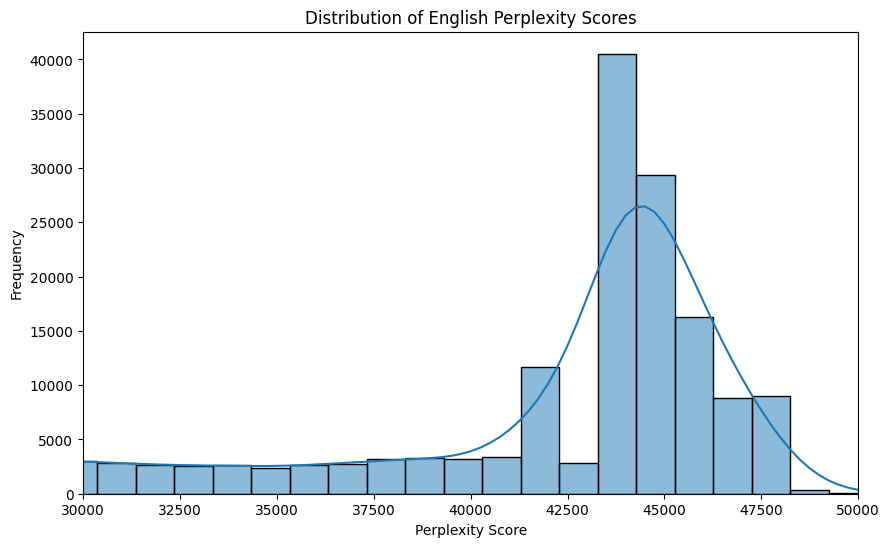

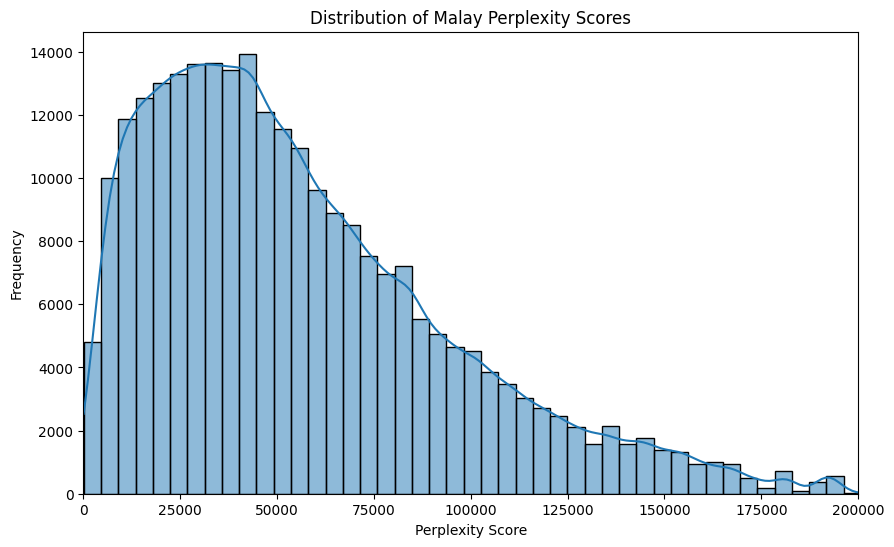

Found 2974 English tweets.
Found 106284 Malay tweets.
Found 146698 Code-mixed tweets.
Formal English vocabulary size: 234375
97825
90249
97825
90249
--- Basilect (Manglish) Examples ---
                                                 tweet    cmi  en_ratio  \
35       scary taichou ur welcome sonny simps i gotchu  20.00      0.80   
99   help rt wts nct dream glitch mode unsealed alb...  28.57      0.71   
107  yogies x wulfz giving away x guaranteed free m...  18.18      0.82   
129  klang valley is hazy again because as of march...  28.57      0.71   
137  unity among members of gabungan rakyat sabah g...  20.00      0.80   
175  the art of flying by little egret at kuala sel...  20.00      0.80   
199  klang valley is hazy again because as of march...  35.71      0.64   
206  wtstaeil sticker photobook kxiaojun jewel univ...  41.67      0.58   
214                 survive togetheraloy only in april  25.00      0.75   
245               helo kg aku kat shah alam bang ha ha  44.44   

In [30]:

# Classify tweets
def classify_tweets(tweets, english_model, malay_model):

    #Compute perplexities for English model on the cleaned tweets 
    english_perplexities = compute_perplexity(english_model, tweets)

    #VISUALISATION OF PERPLEXITY SCORES
    plt.figure(figsize=(10, 6))
    sns.histplot(english_perplexities, bins=50, kde=True)
    plt.title("Distribution of English Perplexity Scores")
    plt.xlabel("Perplexity Score")
    plt.ylabel("Frequency")
    plt.xlim(30000, 50000)  # Adjust x-axis limit for better visibility
    plt.show()


    #Compute perplexities for Malay model on the cleaned tweets 
    malay_perplexities = compute_perplexity(malay_model, tweets)

    #VISUALISATION OF PERPLEXITY SCORES
    plt.figure(figsize=(10, 6))
    sns.histplot(malay_perplexities, bins=50, kde=True)
    plt.title("Distribution of Malay Perplexity Scores")
    plt.xlabel("Perplexity Score")
    plt.ylabel("Frequency")
    plt.xlim(0, 200000)  # Adjust x-axis limit for better visibility
    plt.show()
    

    #print(english_perplexities[:20])  # Print first 10 perplexity scores for verification

    english_threshold = 5000
    malay_threshold = 42500
    english_tweets = []
    malay_tweets = []
    code_mixed_tweets = []

    # Combine your tweets and scores (assuming lists are aligned)
    for tweet, score in zip(cleaned_tweets, english_perplexities):
        if score < english_threshold:
            english_tweets.append(tweet) # Low score = English
        elif score < malay_threshold:
            code_mixed_tweets.append(tweet)
        else:
            malay_tweets.append(tweet)   # High score = Other (Malay)

    print(f"Found {len(english_tweets)} English tweets.")
    print(f"Found {len(malay_tweets)} Malay tweets.")
    print(f"Found {len(code_mixed_tweets)} Code-mixed tweets.")
    
    return english_tweets, malay_tweets, code_mixed_tweets, malay_perplexities, english_perplexities

def build_malay_vocab_from_tweets(malay_tweets, english_model):

    malay_vocab = set()
    
    # Collect the words from the Malay tweets
    for tweet in malay_tweets:
        tokens = tokenizer.tokenize(tweet)
        for token in tokens:
            if token.isalpha(): # Only add alphabetic words
                malay_vocab.add(token.lower())
                
    print(len(malay_vocab))

    # Remove English words
    english_vocab_set = set(english_model.vocab)
    cleaned_malay_vocab = malay_vocab - english_vocab_set
    
    print(len(cleaned_malay_vocab))
    
    return cleaned_malay_vocab


def get_word_language(word, en_vocab, my_vocab):

    word = word.lower()
    if not word.isalpha():
        return 'UNIV'
    
    in_en = word in en_vocab
    in_my = word in my_vocab
    
    if in_en and not in_my:
        return 'EN'
    elif in_my and not in_en:
        return 'MY'
    elif in_en and in_my:
        return 'EN'
    else:
        return 'UNK'

def calculate_cmi(tokens, en_vocab, my_vocab):
    counts = {'EN': 0, 'MY': 0, 'UNIV': 0, 'UNK': 0}
    
    for t in tokens:
        lang = get_word_language(t, en_vocab, my_vocab)
        counts[lang] += 1

    n = len(tokens)
    u = counts['UNIV'] + counts['UNK']
    w_e = counts['EN']
    w_m = counts['MY']

    # Avoid division by zero
    if n - u <= 0:
        return 0.0, 0.0

    # CMI
    max_count = max(w_e, w_m)
    cmi = 100 * (1 - (max_count / (n - u)))
    
    # English Ratio
    en_ratio = w_e / (n - u)

    #Malay ratio
    malay_ratio = w_m / (n - u)
    
    return cmi, en_ratio, malay_ratio


def analyze_mixing_types(tweets, english_model, malay_model, malay_model_vocab):

    results = []
    english_vocab = english_model.vocab

    for tweet in tweets:

        tokens = tokenizer.tokenize(tweet)
        
        cmi, en_ratio, malay_ratio = calculate_cmi(tokens, english_vocab, malay_model_vocab)
        
        # Get Perplexity from our N-gram English model
        test_ngrams = list(ngrams(tokens, english_model.order, pad_left=True, pad_right=True, 
                                  left_pad_symbol='<s>', right_pad_symbol='</s>'))

        # Get perplexity for Malay n-gram model (model_ms)
        test_ngrams_malay = list(ngrams(tokens, malay_model.order, pad_left=True, pad_right=True,
                                       left_pad_symbol='<s>', right_pad_symbol='</s>'))
        
        try:
            pp_score_english = english_model.perplexity(test_ngrams)
        except:
            pp_score_english = float('inf')
            
        try:
            pp_score_malay = malay_model.perplexity(test_ngrams_malay)
        except:
            pp_score_malay = float('inf')

        category = "Unclassified"
        if malay_ratio > 0.95: category = "Monolingual Malay"
        if en_ratio > 0.95: category = "Monolingual English"
        
        # Check if tweet was originally classified as English
        if cmi == 0:
            if en_ratio > 0.9: category = "Monolingual English"
            if en_ratio < 0.1: category = "Monolingual Malay"
            if malay_ratio > 0.9: category = "Monolingual Malay"
            if malay_ratio < 0.1: category = "Monolingual English"
        else:
            # It is mixed. Now, is it Mesolect or Basilect?
            
            # Use both perplexity scores for classification
            # Lower Malay perplexity suggests more Malay-like structure
            # Higher English perplexity suggests deviation from English norms
            
            if pp_score_malay < pp_score_english:
                # More Malay-like structure
                if en_ratio > 0.5:
                    category = "Basilect (Manglish/Dialect)"
                else:
                    category = "Malay with English Loans"
            else:
                # More English-like structure or equal perplexity
                if en_ratio > 0.5 and pp_score_english > 40000:
                    category = "Basilect (Manglish/Dialect)"
                else:
                    category = "Mesolect (Standard Mixing)"

        results.append({
            'tweet': tweet,
            'cmi': round(cmi, 2),
            'en_ratio': round(en_ratio, 2),
            'malay_ratio': round(malay_ratio, 2),
            'perplexity_english': round(pp_score_english, 2),
            'perplexity_malay': round(pp_score_malay, 2),
            'category': category
        })
        
    return results


english_tweets, malay_tweets, code_mixed_tweets, malay_perplexities, english_perplexities = classify_tweets(cleaned_tweets, english_model, model_ms)

# Build the vocabularies using formal English sources

# Ensure the NLTK words corpus is downloaded
try:
    nltk.data.find('corpora/words.zip')
except LookupError:
    nltk.download('words')

# Use the NLTK words corpus to get a list of English words
formal_english_vocab = set(w.lower() for w in words.words() if w.isalpha())

print(f"Formal English vocabulary size: {len(formal_english_vocab)}")



#Informal way
# #english_vocab = set(english_model.vocab)
malay_vocab = build_malay_vocab_from_tweets(malay_tweets, english_model) # New Malay vocab

# Run the analyzer on your code-mixed tweets ONLY
# We don't need to analyze pure English or pure Malay tweets for CMI
# Now pass the Malay model (model_ms) as well
mixed_results = analyze_mixing_types(code_mixed_tweets, english_model, model_ms, malay_vocab)

# View the results
import pandas as pd
df_results = pd.DataFrame(mixed_results)

print("--- Basilect (Manglish) Examples ---")
print(df_results[df_results['category'] == "Basilect (Manglish/Dialect)"].head(10))

print("\n--- Mesolect (Standard Mixed) Examples ---")
print(df_results[df_results['category'] == "Mesolect (Standard Mixing)"].head(10))

print("\n--- Malay with English Loans Examples ---")
print(df_results[df_results['category'] == "Malay with English Loans"].head(10))


In [33]:
category_counts = df_results['category'].value_counts()
category_percentages = df_results['category'].value_counts(normalize=True) * 100

summary = (
    pd.DataFrame({
        "count": category_counts,
        "percentage": category_percentages.round(2)
    })
)

print("\n--- Category Counts and Percentages ---")
print(summary)

 


--- Category Counts and Percentages ---
                             count  percentage
category                                      
Mesolect (Standard Mixing)   79821       54.41
Monolingual English          47774       32.57
Malay with English Loans     10599        7.23
Basilect (Manglish/Dialect)   8504        5.80


/home/moi/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


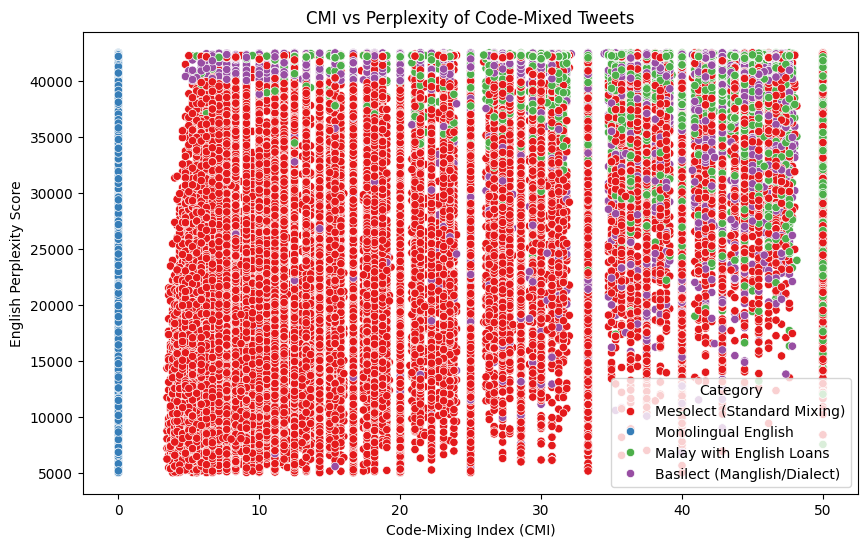

/home/moi/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


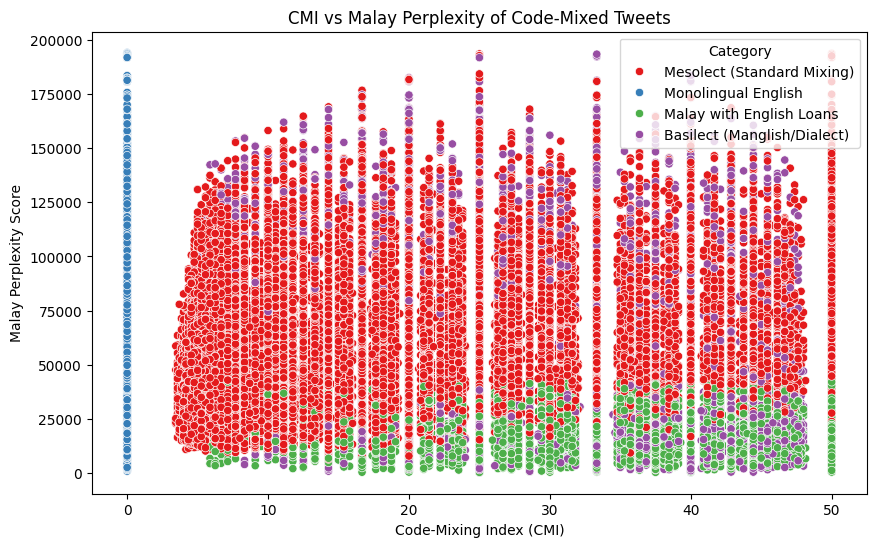

In [34]:

# Plot the resuts
# Plot CMI against english perplexity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_results, x='cmi', y='perplexity_english', hue='category', palette='Set1')
plt.title("CMI vs Perplexity of Code-Mixed Tweets")
plt.xlabel("Code-Mixing Index (CMI)")
plt.ylabel("English Perplexity Score")
plt.legend(title='Category')
plt.show()

# Plot the resuts
# Plot CMI against malay perplexity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_results, x='cmi', y='perplexity_malay', hue='category', palette='Set1')
plt.title("CMI vs Malay Perplexity of Code-Mixed Tweets")
plt.xlabel("Code-Mixing Index (CMI)")
plt.ylabel("Malay Perplexity Score")
plt.legend(title='Category')
plt.show()

In [ ]:
# Print tweets with CMI below 2 and malay perplexity below 25000

print(df_results[(df_results['cmi'] < 2) & (df_results['perplexity_malay'] < 25000)])

                                                    tweet  cmi  en_ratio  \
29      all in for a today the carnival song out today...  0.0       1.0   
31        you walk in on me like this what do you do next  0.0       1.0   
34                          please help me off this floor  0.0       1.0   
160     lets see what people have to say for this got ...  0.0       1.0   
164                                        oh hope to win  0.0       1.0   
...                                                   ...  ...       ...   
146651  so good i had to share check out all the items...  0.0       1.0   
146674                                     a for a friend  0.0       1.0   
146683  so good i had to share check out all the items...  0.0       1.0   
146689  but you know can be found even in the if one o...  0.0       1.0   
146692  thank you guys for the k heres a free little t...  0.0       1.0   

        perplexity_english  perplexity_malay             category  
29                1

In [ ]:

# Analyze grammatical structure
def analyze_grammar(tweet):
    """
    Analyze the grammatical structure of a tweet to detect non-standard English patterns.
    """
    pass


In [ ]:

# Compute additional statistics
def compute_statistics(tweets):
    """
    Compute additional statistics such as sentence length, CMI, Multilingual Index, etc.
    Maybe do one cell / function per statistic instead of putting everything here.
    """
    pass


In [ ]:

# Plot statistics
def plot_statistics(statistics):
    """
    Plot the computed statistics using matplotlib or seaborn.
    """
    pass


In [ ]:

# Main execution
def main():
    """
    Main function to execute the workflow so that the code's execution can be easily managed and stays very lisible.
    """
    pass